In [20]:

import setuptools
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



In [21]:
p_news = pd.read_csv('Political_Bias.csv')
p_news['Bias'].value_counts()

Bias
left          1865
lean left      534
right          529
center         319
lean right     211
Name: count, dtype: int64

In [22]:
label_mapping = {'left': 0, 'lean left': 1, 'center': 2, 'lean right': 3, 'right': 4}

p_news['bias_num'] = p_news['Bias'].map(label_mapping)

In [42]:
p_news.head(5)

,Title,Link,Text,Source,Bias,bias_num
0,John Boltonâ€™s Advice for the â€˜Continuing T...,https://thedispatch.com/article/john-boltons-a...,"with just days until his inauguration, it woul...",TheDispatch,lean right,3
1,Why Shrubland Makes Southern Californiaâ€™s Wi...,https://thedispatch.com/newsletter/techne/why-...,"welcome back to techne! in star trek, writers ...",TheDispatch,lean right,3
2,Los Angelesâ€™ Destruction Was Fueled by Bad P...,https://thedispatch.com/newsletter/capitolism/...,"as fire still rages in the los angeles area, i...",TheDispatch,lean right,3
3,Acquiring Greenland Is a Good Idea. Threatenin...,https://thedispatch.com/article/acquiring-gree...,"whether it was will rogers or tony soprano, th...",TheDispatch,lean right,3
4,Assessing Trumpâ€™s Expansionist Designs,https://thedispatch.com/newsletter/morning/ass...,"happy friday! if anyone was wondering, belgium...",TheDispatch,lean right,3


Setting up Universal Sentence Encoder 

In [2]:
os.system("rm -rf /var/folders/ll/2pp9305j3zg3b9z2c3vf2ycr0000gp/T/tfhub_modules")

0

In [35]:


# # Load the Universal Sentence Encoder model
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# def similarity_matrix(merge_list):
#     # Convert list of sentences into embeddings
#     emb_all = embed(merge_list).numpy()
#     return emb_all


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

p_news['Text'] = p_news['Text'].str.lower()

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # Keep top 20k words, replace unknown words
tokenizer.fit_on_texts(p_news['Text'])  # Fit on the dataset

# Convert text into sequences of word indices
X_sequences = tokenizer.texts_to_sequences(p_news['Text'])

# Pad sequences to ensure uniform length
X_padded = pad_sequences(X_sequences, maxlen=512, padding='post', truncating='post')  # Adjust maxlen as needed




In [36]:

# PRETRAINED GLOVE WORD EMBEDDINGS

glove_path = "glove.6B.300d.txt"  # Change to your file location

# Load GloVe embeddings into a dictionary
embedding_dict = {}
with open(glove_path, "r", encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]  # First token is the word
        vector = np.asarray(values[1:], dtype="float32")  # Rest are embedding values
        embedding_dict[word] = vector

# Define vocabulary size and embedding dimension
vocab_size = 20000  # Must match tokenizer num_words
embedding_dim = 300  # Must match GloVe file

# Get word index from tokenizer
word_index = tokenizer.word_index

# Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill embedding matrix with GloVe vectors
for word, i in word_index.items():
    if i < vocab_size:  # Only use words in vocab limit
        vector = embedding_dict.get(word)  # Lookup word in GloVe
        if vector is not None:
            embedding_matrix[i] = vector  # Assign pre-trained vector


In [25]:
# #feature and class arrays, not yet preprocessed

# merge_list = p_news['Text'].astype(str).tolist()
# X = similarity_matrix(merge_list)
y = p_news['bias_num'].to_numpy()

# print(X.shape)
# print(y.shape)


In [26]:
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.preprocessing import StandardScaler

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)

# for t, te in sss.split(X, y):
#     # Scale the data properly
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X[t])  # Fit only on training data
#     X_test = scaler.transform(X[te])
    
#     y_train, y_test = y[t], y[te]

from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)

for train_idx, test_idx in sss.split(X_padded, y):  # Use padded sequences instead of embeddings
    X_train, X_test = X_padded[train_idx], X_padded[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


In [39]:



# # Define optimizer with a slightly larger learning rate
# optim = Adam(learning_rate=0.001)  

# # Create Neural Network for News Classification:
# news_DNN = Sequential()
# news_DNN.add(Dense(128, input_dim=512, activation='relu', kernel_regularizer=l2(0.01)))  # Increased width
# news_DNN.add(Dropout(0.3))  # Increased dropout for better regularization
# news_DNN.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  
# news_DNN.add(Dropout(0.3))  
# news_DNN.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Added an extra hidden layer  

# # Output layer for 4-class classification
# news_DNN.add(Dense(5, activation='softmax'))

# # Compile model
# news_DNN.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

# # Model summary
# news_DNN.summary()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input layer (word index sequences)
input_layer = Input(shape=(512,))  # 512-token sequence

# Word embedding layer
# Pretrained GloVe Embedding Layer
embedding_layer = Embedding(
    input_dim=vocab_size, output_dim=embedding_dim,  
    weights=[embedding_matrix], input_length=512,  
    trainable=True  # Keep embeddings fixed
)
embedding_output = embedding_layer(input_layer)

# BiLSTM with Increased Dropout & L2 Regularization
lstm_out = Bidirectional(LSTM(128, return_sequences=True, 
                              kernel_regularizer=l2(0.01), 
                              dropout=0.4,  # Increase dropout within LSTM
                              recurrent_dropout=0.3))(embedding_output)

# Attention Mechanism
query = Dense(128, kernel_regularizer=l2(0.01))(lstm_out)
key = Dense(128, kernel_regularizer=l2(0.01))(lstm_out)
value = Dense(128, kernel_regularizer=l2(0.01))(lstm_out)
attention_output = Attention()([query, key, value])

# Global Pooling
flatten = GlobalAveragePooling1D()(attention_output)

# Fully Connected Layers with More Dropout and L2 Regularization
dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(flatten)
dropout1 = Dropout(0.3)(dense1)  # Increased dropout
dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dropout1)
dropout2 = Dropout(0.3)(dense2)  # Increased dropout

# Output Layer
output_layer = Dense(5, activation='softmax')(dropout2)

# Compile Model with Lower Learning Rate
optimizer = Adam(learning_rate=0.0005)  # Reduce LR for better generalization
news_attention_model = Model(inputs=input_layer, outputs=output_layer)
news_attention_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model Summary
news_attention_model.summary()


/Users/jeremy/Documents/DSS-Web-Scraping-Sentiment-Analysis/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 512, 300)  │  6,000,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 512, 256)  │    439,296 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 512, 128)  │     32,896 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 512, 128)  │     32,896 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512, 128)  │     32,896 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 512, 128)  │          0 │ dense_18[0][0],   │
│ (Attention)         │                   │            │ dense_19[0][0],   │
│                     │                   │            │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_3[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 5)         │        165 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,548,485 (24.98 MB)

 Trainable params: 6,548,485 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

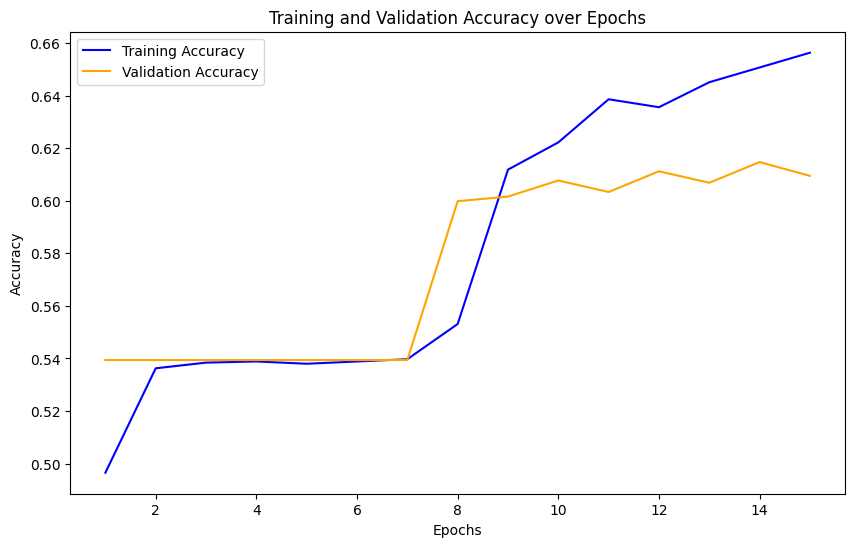

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

m_h = news_attention_model.fit(X_train, y_train, epochs=15, 
    validation_data=(X_test, y_test), 
    batch_size=32, verbose=0, 
    callbacks=[early_stopping])

# Extract the accuracy history from the training process
train_accuracy = m_h.history['accuracy']
val_accuracy = m_h.history['val_accuracy']

# Create a DataFrame for plotting with Seaborn
epochs_completed = len(train_accuracy)

history_df = pd.DataFrame({
    'Epoch': range(1, epochs_completed + 1),
    'Training Accuracy': train_accuracy,
    'Validation Accuracy': val_accuracy
})

# Plot the accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Training Accuracy', data=history_df, label='Training Accuracy', color='blue')
sns.lineplot(x='Epoch', y='Validation Accuracy', data=history_df, label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
